<a href="https://colab.research.google.com/github/AnIsAsPe/Algebra_lineal-para-ML/blob/main/Notebooks/06%20Queries_con_Analisis_Sem%C3%A1ntico_Latente_(LSA)_Expedientes_m%C3%A9dicos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np

from scipy.linalg import sqrtm
from scipy.sparse.linalg import svds  #svd estableciendo k << r

#preprocesar texto
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

nltk.download('stopwords')
nltk.download('wordnet')  #WordNetLemmatizer

#construccion de bolsa de palabras

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Funciones

#### elimina_stopwords()

In [2]:
def elimina_stopwords(texto):
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto) 
  return nuevo_texto

### elimina_puntuacion()

In [3]:
def elimina_puntuacion(texto):
  nuevo_texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)  #puntuación y todo lo que no sea letra ni números
  nuevo_texto = re.sub(" \d+", " ", nuevo_texto)   # elimina números
  return nuevo_texto


#### lematizar_ingles()

In [4]:
lemmatizer = WordNetLemmatizer()

def lematizar(texto):
  texto=texto.split()
  nuevo_texto = " ".join([lemmatizer.lemmatize(i) for i in texto])
  return nuevo_texto

#### stemmer_inglés()

In [5]:
st = PorterStemmer()

def stemmer(texto):
  texto=texto.split()
  nuevo_texto =" ".join([st.stem(i) for i in texto])
  return nuevo_texto

#### preprocesar(texto)


In [6]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion(texto)
  texto = stemmer(texto)
  return(texto)

#### vectorizar_consulta ()

In [7]:
def vectorizar_consulta(texto):
  '''regresa la consulta vectorizada con el mismo vocabulario que el corpus, 
  y pesos tfidf en relación al corpus '''
  q = preprocesar(texto)
  q = tfidf.transform([q])
  q = q.toarray()
  return q


#### reducir_vec_consulta()

In [8]:
def reducir_vec_consulta (q):
  q_k = (q @ np.transpose(Vt_k)) @ (D_k)
  return q_k


#### descomposicion_k()

In [9]:
def descomposicion_k(U_k, D_k, Vt_k):
  ''' a partir de las tres matrices corresponeinetes a la  descomposición 
  truncada en  valores singulares (donde k << r),   devuelve dos matrices 
  la primera de tamaño n por k, y la segunda de dimensión k x d  '''
  MDT_n_k = np.matmul(U_k, sqrtm(D_k))
  MDT_k_d = MDT_kd =  np.matmul(sqrtm(D_k), Vt_k)
  return MDT_n_k, MDT_k_d

#### diagnosticos_similares()

In [10]:
def documentos_similares(q_vec, M, lim = 0):
  q_vec = q_vec.flatten()
  n = M.shape[0]
  sim_coseno = {}
  relevantes={}
  # Calcular similitud coseno
  for i in range(n):
    sim_coseno[i] = np.dot(M[i,:], q_vec) / (np.linalg.norm(M[i,:]) * np.linalg.norm(q_vec))
    if sim_coseno[i] > lim:
      relevantes[i] = sim_coseno[i]
  if not relevantes:
    raise Exception( "No existen documentos similares", lim)

  #Ordenar valores
  relevantes_ordenados = {k:v for k, v in sorted(relevantes.items(),
                                                 key=lambda x: x[1],
                                                 reverse=True)}
  indices = list(relevantes_ordenados.keys())
  
  return corpus.loc[indices, :]

#### precision_sensibilidad()

In [88]:
def precision_sensibilidad(q, M, limites):
  doc_sim_dic = {}
  precision_dic = {}
  sensibilidad_dic = {}
  tolerancias_dic = {}

  for tol in limites:
    tolerancias_dic[tol] = tol
    df_similares = documentos_similares(q, M, lim = tol)
    doc_sim_dic[tol] =df_similares
    Dt = len(df_similares)                       #documentos encontrados 
    Dr = (df_similares['label']==clase_q).sum()  #documentos relevantes encontrados
    Nr = (corpus['label']==clase_q).sum()   #documentos relevantes en todo el corps

    #documentos relevantes encontrados, entre todos los doc encontrados similares
    precision_dic[tol] = Dr / Dt 

    # documentos relevantes encontrados, entre todos los documentos en el corpus
    sensibilidad_dic[tol] = Dr / Nr   #recall

  evaluacion = pd.DataFrame({'precision': precision_dic,
                           'sensibilidad': sensibilidad_dic
                           })
  evaluacion.plot.line(x= 'sensibilidad', y= 'precision', 
                       title ='Precisión vs Sensibilidad',
                       xlim=(0,1), ylim=(0,1))

  plt.grid(alpha=.8, linestyle='--')
  plt.show()
  return evaluacion

# Lectura de datos 
[OHSUMED dataset](https://www.mat.unical.it/OlexSuite/Datasets/SampleDataSets-about.htm)




In [118]:
datos = pd.read_csv('https://raw.githubusercontent.com/danieljfeller/medline-multilabel/master/data/processed/ohsumed_abstracts.csv', 
                    usecols=[0,1,2], index_col=0,)
print(datos.shape)
datos.head()

(13924, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."


In [13]:
len(datos['label'].value_counts())

23

Los documentos están catalogados en 23 categorías

#Separar el corpus para tener documentos de consulta

In [14]:
#separamos una muestra aleatoria de 10 documentos, que serán nuestras consulatas
consultas_idx = datos.sample(10, random_state=3).index 
consultas = datos.iloc[consultas_idx,:].copy()
consultas

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [15]:
#dejamos el resto de documentos como nuestro corpus
corpus = pd.concat([datos,consultas]).drop_duplicates(keep=False).reset_index(drop=True)
consultas = consultas.reset_index(drop=True)
print(corpus.shape)
corpus.tail()

(13914, 2)


,label,doc
13909,11,Results of blepharoptosis surgery with early ...
13910,11,"A century of cerebral achromatopsia, This rev..."
13911,11,Intraocular lens implantation after penetrati...
13912,11,Reproducibility of topographic measurements o...
13913,11,Cyclocryotherapy in selected cases of congeni...


In [16]:
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


# Preprocesamiento de texto

In [17]:
ejemplo = np.random.choice(corpus['doc'])
print(len(ejemplo))
ejemplo

1321


' Lymphocytes and nonlymphoid cells in human nasal polyps, Immunohistochemical stainings were performed on polyp specimens of 48 patients and on mucosal biopsy specimens of the middle and inferior turbinates of 23 and 28 patients. respectively. Significantly more CD8+ (suppressor/cytotoxic) than CD4+ (helper/inducer) cells were found in the polyps. The number of CD2+. CD4+. and CD8+ lymphocytes in nasal polyps were very similar to the number in the macroscopically unaffected mucosa of the middle turbinates. whereas scores in the inferior turbinates were lower. In healthy subjects. the differences were smaller. CD22+ B cells were detected in varying numbers in the polyps in more or less organized clusters. Significantly more HLA-DR+ cells were found in polyps and middle turbinates than in the inferior turbinates. Eosinophils were found in moderate to large numbers in polyps of 77% of the patients. Mast cells and plasma cells were detected in moderate numbers. whereas neutrophils were fo

#### Transformar texto a minúsculas

In [18]:
ejemplo = ejemplo.lower()
print(len(ejemplo))
ejemplo

1321


' lymphocytes and nonlymphoid cells in human nasal polyps, immunohistochemical stainings were performed on polyp specimens of 48 patients and on mucosal biopsy specimens of the middle and inferior turbinates of 23 and 28 patients. respectively. significantly more cd8+ (suppressor/cytotoxic) than cd4+ (helper/inducer) cells were found in the polyps. the number of cd2+. cd4+. and cd8+ lymphocytes in nasal polyps were very similar to the number in the macroscopically unaffected mucosa of the middle turbinates. whereas scores in the inferior turbinates were lower. in healthy subjects. the differences were smaller. cd22+ b cells were detected in varying numbers in the polyps in more or less organized clusters. significantly more hla-dr+ cells were found in polyps and middle turbinates than in the inferior turbinates. eosinophils were found in moderate to large numbers in polyps of 77% of the patients. mast cells and plasma cells were detected in moderate numbers. whereas neutrophils were fo

#### Quitar puntuación

In [19]:
ejemplo = elimina_puntuacion(ejemplo)
print(len(ejemplo))
ejemplo

1278


' lymphocytes and nonlymphoid cells in human nasal polyps immunohistochemical stainings were performed on polyp specimens of  patients and on mucosal biopsy specimens of the middle and inferior turbinates of  and  patients respectively significantly more cd8 suppressor cytotoxic than cd4 helper inducer cells were found in the polyps the number of cd2 cd4 and cd8 lymphocytes in nasal polyps were very similar to the number in the macroscopically unaffected mucosa of the middle turbinates whereas scores in the inferior turbinates were lower in healthy subjects the differences were smaller cd22 b cells were detected in varying numbers in the polyps in more or less organized clusters significantly more hla dr cells were found in polyps and middle turbinates than in the inferior turbinates eosinophils were found in moderate to large numbers in polyps of  of the patients mast cells and plasma cells were detected in moderate numbers whereas neutrophils were found in  of the patients in the mid

#### Quitar Palabras Irrelevantes ("Stopwords")

In [20]:
ejemplo = elimina_stopwords(ejemplo)
print(len(ejemplo))
ejemplo

965


' lymphocytes nonlymphoid cells human nasal polyps immunohistochemical stainings performed polyp specimens patients mucosal biopsy specimens middle inferior turbinates patients respectively significantly cd8 suppressor cytotoxic cd4 helper inducer cells found polyps number cd2 cd4 cd8 lymphocytes nasal polyps similar number macroscopically unaffected mucosa middle turbinates whereas scores inferior turbinates lower healthy subjects differences smaller cd22 b cells detected varying numbers polyps less organized clusters significantly hla dr cells found polyps middle turbinates inferior turbinates eosinophils found moderate large numbers polyps patients mast cells plasma cells detected moderate numbers whereas neutrophils found patients middle inferior turbinates varying small numbers eosinophils mast cells plasma cells neutrophils found considering findings role chronic inflammation cell dependent disturbances discussed regard pathogenesis nasal polyps '

## Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

Referencia: 

https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc

In [21]:
ejemplo_lema = lematizar(ejemplo)
print(len(ejemplo_lema))
ejemplo_lema

917


'lymphocyte nonlymphoid cell human nasal polyp immunohistochemical staining performed polyp specimen patient mucosal biopsy specimen middle inferior turbinate patient respectively significantly cd8 suppressor cytotoxic cd4 helper inducer cell found polyp number cd2 cd4 cd8 lymphocyte nasal polyp similar number macroscopically unaffected mucosa middle turbinate whereas score inferior turbinate lower healthy subject difference smaller cd22 b cell detected varying number polyp le organized cluster significantly hla dr cell found polyp middle turbinate inferior turbinate eosinophil found moderate large number polyp patient mast cell plasma cell detected moderate number whereas neutrophil found patient middle inferior turbinate varying small number eosinophil mast cell plasma cell neutrophil found considering finding role chronic inflammation cell dependent disturbance discussed regard pathogenesis nasal polyp'

In [22]:
ejemplo_stem = stemmer(ejemplo)
print(len(ejemplo_stem))
ejemplo_stem

817


'lymphocyt nonlymphoid cell human nasal polyp immunohistochem stain perform polyp specimen patient mucos biopsi specimen middl inferior turbin patient respect significantli cd8 suppressor cytotox cd4 helper induc cell found polyp number cd2 cd4 cd8 lymphocyt nasal polyp similar number macroscop unaffect mucosa middl turbin wherea score inferior turbin lower healthi subject differ smaller cd22 b cell detect vari number polyp less organ cluster significantli hla dr cell found polyp middl turbin inferior turbin eosinophil found moder larg number polyp patient mast cell plasma cell detect moder number wherea neutrophil found patient middl inferior turbin vari small number eosinophil mast cell plasma cell neutrophil found consid find role chronic inflamm cell depend disturb discuss regard pathogenesi nasal polyp'

## Todo junto

In [23]:
%%time
corpus['doc_pp'] = corpus['doc'].apply(preprocesar)


CPU times: user 38.6 s, sys: 434 ms, total: 39 s
Wall time: 39.3 s


In [24]:
corpus.head()

,label,doc,doc_pp
0,16,Improved outcome at 28 days of age for very l...,improv outcom day age low birth weight infant ...
1,5,Chylothorax after posterior spinal instrument...,chylothorax posterior spinal instrument fusion...
2,16,Childhood pulmonary function following hyalin...,childhood pulmonari function follow hyalin mem...
3,8,Treatment of atelectasis of upper lung lobes....,treatment atelectasi upper lung lobe select br...
4,21,"Decision analysis, public health policy, and ...",decis analysi public health polici isoniazid c...


# Bolsa de palabras peso TF-IDF

Usaremos la funcion **```TFidfVectorize```** de skleran
Notar que el paramentro **```min_df```** hace la función "cut-off" para no considerar los términos con poca frecuencia en el documento.
En este ejercio se ha establecido una frecuencia de al menos 70 documentos que contengan el término que corresponde a cerca del 0.5% de todos los documentos


In [25]:
tfidf = TfidfVectorizer(min_df=70)
mdt_tfidf = tfidf.fit_transform(corpus['doc_pp']) 
palabras = tfidf.get_feature_names()
MDT = pd.DataFrame(mdt_tfidf.todense(), 
                              index=corpus.index, 
                              columns=palabras)
print(MDT.shape)
MDT

(13914, 2049)


,abdomin,abil,abl,abnorm,abscess,absenc,absent,absolut,absorpt,abstract,abus,acceler,accept,access,accompani,accomplish,accord,account,accumul,accur,accuraci,acet,achiev,acid,acquir,across,act,action,activ,actual,actuari,acut,ad,adapt,addit,address,adenocarcinoma,adenoma,adenosin,adequ,...,wall,warrant,water,wave,way,weak,week,weekli,weight,well,western,wherea,whether,white,whole,whose,wide,widespread,withdraw,within,without,wk,woman,women,word,work,worker,world,wors,worsen,would,wound,year,yet,yield,york,young,younger,yr,zone
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.062682,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.160756,0.0,0.0,0.0,0.050065,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058752,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.071739,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.153212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.091594,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045617,0.0,0.0,0.0,0.087732,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.081494,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.292889,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.067965,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
13910,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306138,0.0,0.0,0.0,0.000000,0.094699,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
13911,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.073893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0

In [26]:
#¿qué porcentaje de celdas tienen cero?

no_ceros = MDT.astype(bool).sum().sum()  #cantidad de ceros en todo el dataframe
total = MDT.shape[0] * MDT.shape[1]

(1- no_ceros/total) * 100

97.33475726545264

# Descomposición en valores singulares (SVD) con numpy

$~~ M = U~D~V^{T}$

$~~ M = 
\sum_{i=1}^{min(m, n)}s_{i}\cdot u_{1}v_{i}^{T}
$






In [27]:
# Ver las dimensiones de las tres matrices
# Descomposición Matriz Documento Término  (3 min)
U_, sigma_, Vt_ = np.linalg.svd(MDT)

# obtener con los valores seingulare (sigma) la matriz D
D_ = np.diag(sigma_)

print(U_.shape, D_.shape, Vt_.shape)

(13914, 13914) (2049, 2049) (2049, 2049)


In [28]:
sigma_.shape

(2049,)

In [29]:
#¿cuántos valores de sigma son distintos de cero?
sigmas = sigma_[np.nonzero(sigma_)]
len(sigmas)

2049

**Esto quiere decir que la matriz inicial no es singular, por tanto  r = d**

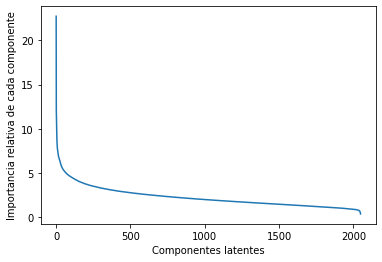

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 2049
sns.lineplot(x=list(range(len(sigma_[0:k]))), y = sigma_[0:k])
plt.ylabel('Importancia relativa de cada componente')
plt.xlabel('Componentes latentes')
plt.show()

# Análisis Semántico Latente
 SVD especificando $k<r$ con scipy


$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\hat{M} = U_{k}~~D_{k}~~V_{k}^{T}
$

In [60]:
%%time
#from scipy.sparse.linalg import svds
U_k, sigmas_k, Vt_k = svds(MDT, k=100)
D_k = np.diag(sigmas_k)

CPU times: user 23.9 s, sys: 15.3 s, total: 39.2 s
Wall time: 20 s


In [61]:
#docs-temas / relevancia temas / temas-doc

U_k.shape, D_k.shape, Vt_k.shape

((13914, 100), (100, 100), (100, 2049))


### Obtener la matriz reducida de latent semantic análisis que representa a cada documento con k términos

$ M_{n\times{k}} = U_{k}~~\sqrt{D_{k}} $

In [62]:
M1 = np.matmul(U_k, sqrtm(D_k)) 
M1.shape

(13914, 100)

### Obtener la matriz reducida de latent que representa a cada palabra con k términos
$ M_{k\times{d}} = \sqrt{D_{k}}~~{V_{k}}^T~~ $

In [63]:
M2 =  np.matmul(sqrtm(D_k), Vt_k) 
M2.shape

(100, 2049)

por facilidad la función **```descomposicion_k()```** regresa las dos matrices obtenidas en las líneas anteriores



In [64]:
MDT_nk, MDT_kd = descomposicion_k(U_k, D_k, Vt_k )

print(MDT_nk.shape, MDT_kd.shape)

(13914, 100) (100, 2049)


In [76]:
#renglones reducidos y columnas reducidas
(M1).shape, np.transpose(M2).shape


((13914, 100), (2049, 100))

## Vectorizar consulta (texto nuevo)


**debemos vectorizar nuestra consulta utilizando el mismo vocabulario que el corpus**

In [65]:
#podemos usar cualquier texto
q = vectorizar_consulta('heart desease')
q.shape

(1, 2049)

como vemos, tenemos ahora la consulta con las d dimensiones que corresponden al vocabulario del corpus.



**ahora es necesario reducir el vector, usando nuestras matrices**

$\hat{q} = 
q~V_{k}~D
$

In [66]:
q_k = (q @ np.transpose(Vt_k)) @ (D_k)
print(q.shape, np.transpose(Vt_k).shape, D_k.shape )
print(q_k.shape)

(1, 2049) (2049, 100) (100, 100)
(1, 100)


por facilidad guardamos el código anterior en la función **```reducir_vec_consulta()```**



In [67]:
q_k = reducir_vec_consulta(q)
q_k.shape

(1, 100)

In [68]:
 # elegir aleatoriamente uno de los diagnósticos como consulta
 # guardamos la clase y el texto
q_idx = 1
clase_q =consultas.iloc[q_idx,0]   
Q = consultas.iloc[q_idx,1]

print('Clase de la consulta:' , clase_q,'\n')
Q

Clase de la consulta: 10 



' The community hospital-based stroke programs in North Carolina, Oregon and New York--V. Stroke diagnosis: factors influencing the diagnostic evaluation of patients following acute stroke, Among the 4129 patients of the Community Hospital-based Stroke Program. 30% had an unspecified stroke diagnosis. Since specific diagnosis and. perhaps. eventual treatment. derives in part from diagnostic testing. we examined the effect of clinical condition. geographic and demographic factors on the incidence of certain diagnostic tests after acute stroke. In this multivariable analysis. race. sex. history of hypertension and history of diabetes did not influence the chance of having any test. but older age strongly reduced the chances of receiving extensive evaluation. When CT scanning was available. the utilization of a CT as well as other diagnostic studies including cerebral angiography. radionuclide brain scan. EEG and EKG was increased. The odds of receiving a CT scan increased if the patient 

In [69]:
q = vectorizar_consulta(Q)  # preprocesamos y vectorizamos 
q_k = reducir_vec_consulta(q)  # reducimos a k dimensiones 
print ('Dimensión vector q  :', q.shape) 
print ('Dimensión vector q_k:', q_k.shape)

Dimensión vector q  : (1, 2049)
Dimensión vector q_k: (1, 100)


## Obtener documentos relevantes a la consulta

In [99]:
tol = .4  # valor a partir del que se considera un doc similar a la consulta

doc_sim = documentos_similares(q_k, MDT_nk, lim = tol)


Dt = len(doc_sim)                       #documentos encontrados 
Dr = (doc_sim['label']==clase_q).sum()  #documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   #documentos relevantes en todo el corps

#documentos relevantes encontrados, entre todos los doc encontrados similares
precision = Dr / Dt 

#documentos relevantes encontrados, entre todos los doc relevantes en el corpus
sensibilidad = Dr / Nr   #recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  153
      Documentos relevantes encontrados:  62
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.41
                           Sensibilidad: 0.05


In [100]:
tol = .2  # valor a partir del que se considera un doc similar a la consulta

doc_sim = documentos_similares(q, MDT.to_numpy(), lim = tol)


Dt = len(doc_sim)                       #documentos encontrados 
Dr = (doc_sim['label']==clase_q).sum()  #documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   #documentos relevantes en todo el corps

#documentos relevantes encontrados, entre todos los doc encontrados similares
precision = Dr / Dt 

# documentos relevantes encontrados, entre todos los docrelevantes en el corpus
sensibilidad = Dr / Nr   #recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  62
      Documentos relevantes encontrados:  43
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.69
                           Sensibilidad: 0.04


## Evaluación de la recuperación de información

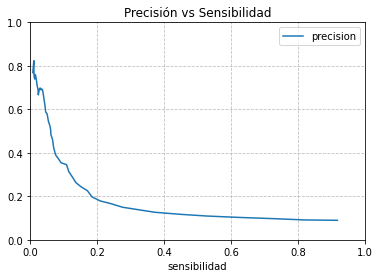

In [113]:
tols = np.linspace(0.01, 0.3,50)
evaluacion = precision_sensibilidad(q, MDT.to_numpy(),tols)

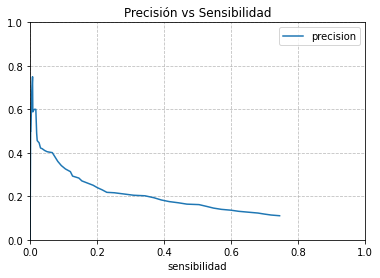

In [115]:
tols = np.linspace(0.15, 0.5, 50)
evaluacion_k = precision_sensibilidad(q_k, MDT_nk, tols)

In [116]:
eval = pd.merge(evaluacion_k, evaluacion, how='left', on= evaluacion.index, suffixes  = ('_k',''))
eval.head()

,key_0,precision_k,sensibilidad_k,precision,sensibilidad
0,0.010000,0.110679,0.745291,0.089637,0.918100
1,0.015918,0.113934,0.719902,0.091341,0.819001
2,0.021837,0.118208,0.700246,0.097016,0.732187
3,0.027755,0.123056,0.680590,0.102677,0.628174
4,0.033673,0.126870,0.652744,0.109214,0.529075


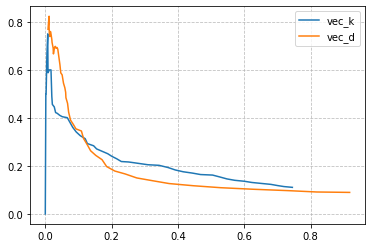

In [117]:


figsize =(4,4)
plt.plot(eval['sensibilidad_k'], eval['precision_k'], label='vec_k')
plt.plot(eval['sensibilidad'],  eval['precision'], label='vec_d')

plt.xlim=(.15,1)

plt.legend()
plt.grid(alpha=.8, linestyle='--')
plt.show()